# FINAL PROJECT - SONG'S WORTH TO LISTEN PREDICTION

## Thư viện

In [ ]:
#!conda install nltk
#!pip install nltk

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

sid = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin

set_config(display='diagram') # Để trực quan hóa pipeline

## Tải dữ liệu

In [8]:
data_df = pd.read_csv('data/data.csv')

## Khám phá dữ liệu

### Dữ liệu có bao nhiêu dòng, bao nhiêu cột?

In [9]:
data_df.shape

(1600, 20)

### Mỗi dòng có ý nghĩa như thế nào?

Quan sát sơ bộ dữ liệu, ta thấy mỗi dòng dữ liệu sẽ có thông tin về một bài hát, và không có các dòng có ý nghĩa khác nhau.

### Kiểm tra xem có dòng dữ liệu nào bị lặp không (cùng tên bài hát - nghệ sĩ)?

Sở dĩ, ta chỉ kiểm tra xem các dòng dữ liệu có lặp 2 thuộc tính "tên bài hát" và "tên nghệ sĩ" hay không, mà không xét nguyên dòng dữ liệu là bởi vì trong dòng dữ liệu sẽ có thông tin về thứ hạng của bài hát cũng như năm tương ứng. 

Sẽ tồn tại những bài hát gặp trường hợp có mặt trên bảng xếp hạng của năm trước và vẫn tiếp tục xuất hiện trên bảng xếp hạng năm tiếp theo cùng với thứ hạng khác.

Vậy nên khi kiểm tra dữ liệu lặp ta sẽ chỉ kiểm tra 2 thuộc tính "tên bài hát" và "tên nghệ sĩ".

In [10]:
#Check duplicated Song - Artist
data_df['check'] = data_df['name'].str.lower() + data_df['artist'].str.lower()
data_df['check'].duplicated().sum()

161

In [11]:
#Remove these duplicated songs
data_df.drop_duplicates(['check'], inplace = True)

In [12]:
#Re-check the dataframe
data_df['check'].duplicated().sum()

0

In [13]:
data_df.drop('check', axis = 1, inplace = True)
data_df

,rank,name,artist,year,pop_artist,artist_followers,available_market,pop_track,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,lyrics
0,1,We Belong Together,Mariah Carey,2005,78.0,6995024.0,3.0,69.0,0.03390,0.837,201400.0,0.462,0.000000,0.0900,-7.890,0.0601,139.986,4.0,0.762,"Sweet love, yeah I didn't mean it when I said..."
1,2,Hollaback Girl,Gwen Stefani,2005,75.0,4859586.0,165.0,68.0,0.35000,0.926,199853.0,0.916,0.000006,0.0234,-2.221,0.0929,110.007,4.0,0.904,"Uh-huh, this my shit All the girls, stomp your..."
2,3,Let Me Love You,Mario,2005,67.0,2367100.0,143.0,72.0,0.23500,0.656,256733.0,0.578,0.000000,0.1180,-8.970,0.0922,94.514,4.0,0.556,"Mmmm, ah Mmmm, yeah Mmmm Yeah, yeah, yeah Mmmm..."
3,4,Since U Been Gone,Kelly Clarkson,2005,75.0,7955803.0,178.0,70.0,0.00165,0.662,188960.0,0.741,0.030300,0.1140,-5.406,0.0334,131.000,4.0,0.404,"Here's the thing, we started out friends It wa..."
4,5,"1, 2 Step",Ciara featuring Missy Elliott,2005,72.0,5209750.0,178.0,73.0,0.04200,0.944,203787.0,0.511,0.001070,0.0379,-10.960,0.1610,113.046,4.0,0.842,Ladies and Gentlemen Ladies and Gentlemen This...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,96,More Than My Hometown,Morgan Wallen,2020,83.0,2238350.0,178.0,74.0,0.61500,0.620,216573.0,0.869,0.000000,0.1310,-5.479,0.0462,126.019,4.0,0.597,"Girl, our mamas are best friends and so are we..."
1596,97,Lovin' on You,Luke Combs,2020,82.0,5474485.0,178.0,69.0,0.00165,0.572,194867.0,0.949,0.000195,0.1630,-4.865,0.0600,118.974,4.0,0.530,Don't get me wrong I like a bobber on the wate...
1597,98,Said Sum,Moneybagg Yo,2020,80.0,2307788.0,178.0,69.0,0.01850,0.929,155168.0,0.667,0.000000,0.1000,-6.789,0.3530,126.998,4.0,0.274,"Turn me up, YC Huh? What? Ah, I thought a bro..."
1598,99,Slide,H.E.R. featuring YG,2020,79.0,4240318.0,177.0,67.0,0.08070,0.832,238321.0,0.469,0.000008,0.2070,-9.141,0.3390,97.023,4.0,0.197,You always wearin' them glasses You don't wann...


### Mỗi cột có ý nghĩa gì?

Đọc từ file `summary.csv`

In [14]:
pd.set_option('display.max_colwidth', None)

In [15]:
try:
  df_meaning = pd.read_csv('data/summary.csv')
except:
  df_meaning = pd.read_csv('/content/drive/MyDrive/KHTN/intro2ds/data/summary.csv')
df_meaning

,Properties,Meaning
0,rank,Rank on the year chart
1,name,Name of track
2,artist,Name the performer of the song
3,year,Year of the song chart reached the rank
4,pop_artist,"The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist's popularity is calculated from the popularity of all the artist's tracks."
5,artist_followers,Number of followers
6,available_market,Number of countries that have released the track
7,pop_track,"The popularity of the track. The value will be between 0 and 100, with 100 being the most popular."
8,acousticness,A measure from 0.0 to 1.0 of whether the track is acoustic.
9,danceability,Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo rhythm stability beat strength and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


## Đưa ra câu hỏi cần trả lời

Từ bước trên, ta có thể thấy được trong bộ dữ liệu đầu vào sẽ có các thông tin về nghệ sĩ, về audio của bài hát cũng như lời bài hát.

Từ những thông tin liên quan đến bài hát này nhóm muốn trả lời câu hỏi rằng: **"Bài hát nào đáng nghe nhất?"**. Và nhóm giả định rằng bài hát đáng nghe sẽ là bài hát thuộc top 35 trong số 100 bài hát nằm trong bảng xếp hạng Billboard Yead-end Hot 100. 

Như vậy, câu hỏi cần trả lời sẽ là:

*Output - đáng nghe/không đáng nghe* ~ được tính từ *input - thông tin bài hát (thông tin audio, nghệ sĩ, lời bài hát)* ~ theo công thức nào?

Sau khi trả lời được câu hỏi này, đặt vào trường hợp người dùng là những người bận rộn, không có nhiều thời gian rảnh rỗi. Vậy từ những thông tin về audio, nghệ sĩ cũng như lời bài hát ta mong đợi rằng có thể dự đoán được rằng liệu bài hát đó có đáng để nghe theo như tiêu chí đặt ra ban đầu của nhóm hay không? (nằm trong top 35 bảng xếp hạng cuối năm)

Vì trong bộ dữ liệu chưa có cột output nên ta sẽ xây dựng cột output, đặt tên là `hit` được tính từ cột `rank`.

In [16]:
pd.reset_option('display')

In [17]:
data_df['hit'] = np.where(data_df['rank'] <= 35, 1, 0)
data_df

,rank,name,artist,year,pop_artist,artist_followers,available_market,pop_track,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,lyrics,hit
0,1,We Belong Together,Mariah Carey,2005,78.0,6995024.0,3.0,69.0,0.03390,0.837,201400.0,0.462,0.000000,0.0900,-7.890,0.0601,139.986,4.0,0.762,"Sweet love, yeah I didn't mean it when I said...",1
1,2,Hollaback Girl,Gwen Stefani,2005,75.0,4859586.0,165.0,68.0,0.35000,0.926,199853.0,0.916,0.000006,0.0234,-2.221,0.0929,110.007,4.0,0.904,"Uh-huh, this my shit All the girls, stomp your...",1
2,3,Let Me Love You,Mario,2005,67.0,2367100.0,143.0,72.0,0.23500,0.656,256733.0,0.578,0.000000,0.1180,-8.970,0.0922,94.514,4.0,0.556,"Mmmm, ah Mmmm, yeah Mmmm Yeah, yeah, yeah Mmmm...",1
3,4,Since U Been Gone,Kelly Clarkson,2005,75.0,7955803.0,178.0,70.0,0.00165,0.662,188960.0,0.741,0.030300,0.1140,-5.406,0.0334,131.000,4.0,0.404,"Here's the thing, we started out friends It wa...",1
4,5,"1, 2 Step",Ciara featuring Missy Elliott,2005,72.0,5209750.0,178.0,73.0,0.04200,0.944,203787.0,0.511,0.001070,0.0379,-10.960,0.1610,113.046,4.0,0.842,Ladies and Gentlemen Ladies and Gentlemen This...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,96,More Than My Hometown,Morgan Wallen,2020,83.0,2238350.0,178.0,74.0,0.61500,0.620,216573.0,0.869,0.000000,0.1310,-5.479,0.0462,126.019,4.0,0.597,"Girl, our mamas are best friends and so are we...",0
1596,97,Lovin' on You,Luke Combs,2020,82.0,5474485.0,178.0,69.0,0.00165,0.572,194867.0,0.949,0.000195,0.1630,-4.865,0.0600,118.974,4.0,0.530,Don't get me wrong I like a bobber on the wate...,0
1597,98,Said Sum,Moneybagg Yo,2020,80.0,2307788.0,178.0,69.0,0.01850,0.929,155168.0,0.667,0.000000,0.1000,-6.789,0.3530,126.998,4.0,0.274,"Turn me up, YC Huh? What? Ah, I thought a bro...",0
1598,99,Slide,H.E.R. featuring YG,2020,79.0,4240318.0,177.0,67.0,0.08070,0.832,238321.0,0.469,0.000008,0.2070,-9.141,0.3390,97.023,4.0,0.197,You always wearin' them glasses You don't wann...,0


## Tiếp tục khám phá dữ liệu để tách các tập

Cột *Ouput* là cột do nhóm xây dựng, tuy nhiên ta vẫn sẽ khám phá lại cột *Output* này để kiểm tra lại 1 lần nữa:
- Cột thuộc kiểu dữ liệu gì?
- Cột này có dữ liệu thiếu không?
- Tỉ lệ các lớp trong cột này là bao nhiêu?

In [18]:
# Kiểu dữ liệu cột output - hit
data_df['hit'].dtype

dtype('int64')

In [19]:
# Kiểm tra xem có dữ thiệt thiếu không?
data_df['hit'].isna().sum()

0

In [20]:
# Tỉ lệ của các lớp trong cột
data_df['hit'].value_counts(normalize = True) * 100

0    64.697707
1    35.302293
Name: hit, dtype: float64

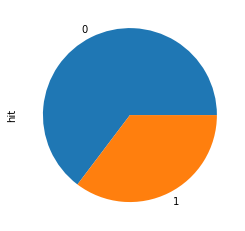

In [21]:
data_df['hit'].value_counts().plot.pie();

## Tách các tập

Ở đây, vì dữ liệu không có nhiều, nên nhóm dự định sẽ sử dụng phương pháp k-fold cross validation để cải thiện hiệu quả trong việc huấn luyện.

Nhóm sẽ tách dữ liệu ban đầu thành 2 tập: (train + validation) và test

In [22]:
y_sr = data_df['hit']
X_df = data_df.drop('hit', axis = 1)

In [23]:
# Tách tập (train + validation) và tập test theo tỉ lệ 85%:15%
train_X_df, test_X_df, train_y_sr, test_y_sr = \
                              train_test_split(X_df, y_sr, 
                                               test_size=0.15, 
                                               stratify=y_sr, 
                                               random_state=0)

In [24]:
train_X_df.shape

(1223, 20)

In [25]:
train_y_sr.shape

(1223,)

In [26]:
test_X_df.shape

(216, 20)

In [27]:
test_y_sr.shape

(216,)

Hiện tại, ở bước này ta đã chia dữ liệu thành 2 tập (train + valid)/test với tỉ lệ 85%, 15%. Tiếp sau, ta sẽ tiếp tục khám phá dữ liệu trên tập huấn luyện, sau đó tiến hành các bước tiền xử lý và mô hình hóa.

## Khám phá dữ liệu trên tập huấn luyện

### Các cột input đang có kiểu dữ liệu gì?

In [28]:
train_X_df.dtypes

rank                  int64
name                 object
artist               object
year                  int64
pop_artist          float64
artist_followers    float64
available_market    float64
pop_track           float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
lyrics               object
dtype: object

Ở bước này, ta thấy có vẻ các cột đều có kiểu dữ liệu phù hợp.

### Với những cột input có kiểu dữ liệu dạng số, dữ liệu được phân bổ như thế nào?

Trong tập dữ liệu huấn luyện `train_X_df` có 17/20 cột không phải là object, tuy nhiên 3 cột `rank`, `year` và `time_signature` thì thật ra là dạng categorical.

In [29]:
train_X_df.dtypes[train_X_df.dtypes != object]

rank                  int64
year                  int64
pop_artist          float64
artist_followers    float64
available_market    float64
pop_track           float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
dtype: object

Ta sẽ xem các cột này có dữ liệu phân bố như thế nào

In [30]:
ignore = ['rank', 'year', 'time_signature']
num_cols = train_X_df.dtypes[train_X_df.dtypes != object].index.to_list()
num_cols = [x for x in num_cols if x not in ignore]
num_cols

['pop_artist',
 'artist_followers',
 'available_market',
 'pop_track',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

In [31]:
df = train_X_df[num_cols]
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
df.agg([missing_percentage, 'min', median, 'max'])

,pop_artist,artist_followers,available_market,pop_track,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
missing_percentage,0.2,0.2,0.2,0.2,0.200000,0.200,0.2,0.2000,0.200,0.200,0.200,0.2000,0.200,0.2000
min,4.0,96.0,1.0,0.0,0.000024,0.162,113000.0,0.0565,0.000,0.021,-21.402,0.0232,53.863,0.0383
median,80.0,6347305.5,176.0,68.0,0.100000,0.700,222300.0,0.7000,0.000,0.100,-5.400,0.1000,120.100,0.5000
max,100.0,84544667.0,178.0,91.0,0.978000,0.975,688453.0,0.9830,0.918,0.888,-1.190,0.5880,210.857,0.9740


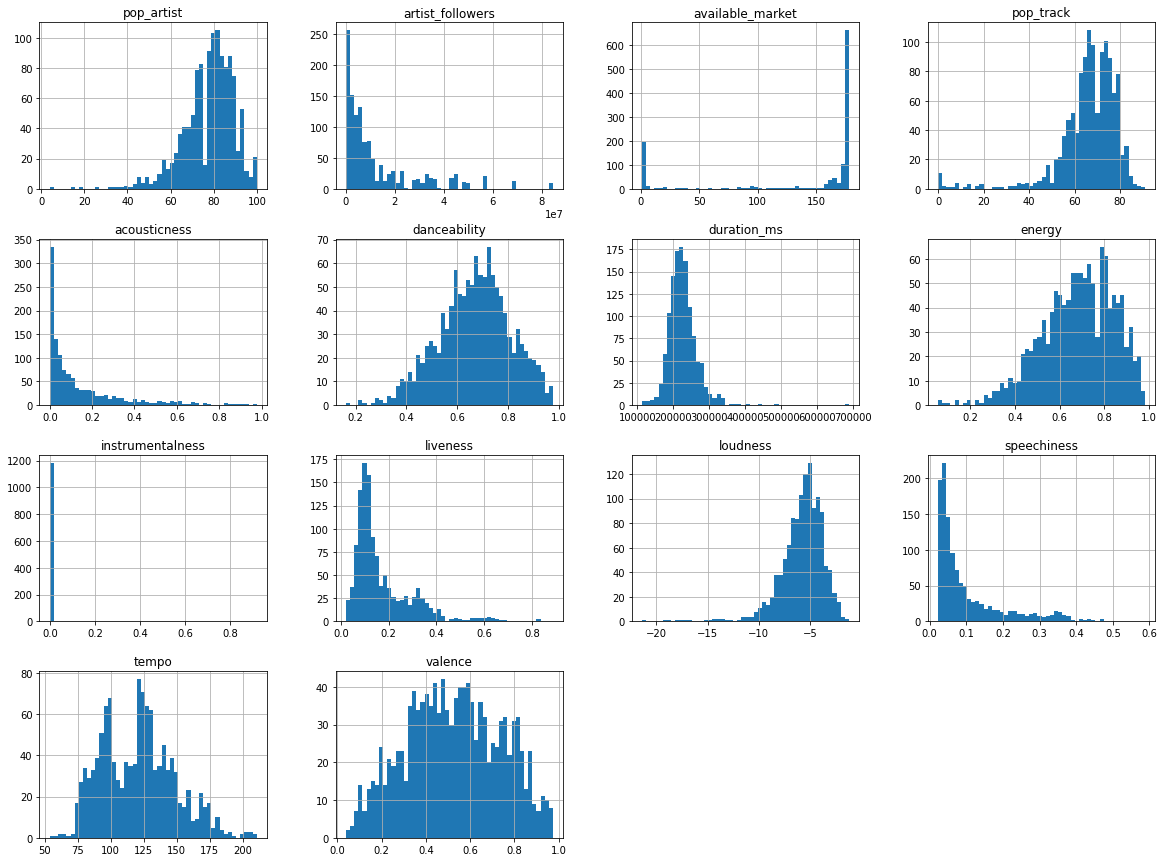

In [32]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

Qua đây ta có một số nhận xét: 
- Ta thấy có 1 cột phân cực quá mạnh `instrumentalness`. Phân cực quá mạnh cho thấy ít nói lên được điều gì về bài hát. Điều này có thể dẫn đến do:
    - `instrumentaless` là thuộc tính mà Spotify dự đoán khả năng bản nhạc không tồn tại giọng hát (vocal). Chỉ số này càng gần về 1, thì có khả năng cao rằng bài hát này "không bao gồm giọng hát".
    - Tuy nhiên, trong bảng xếp hạng hot 100 thì có thể nói tất cả các bài hát lọt vào bảng xếp hàng thì là những bản gốc (original) "có bao gồm giọng hát" của bài hát chứ không phải là những bản beat, karaoke version...
    - Nên, đã dẫn tới thuộc tính `instrumentaless` gần như luôn bằng 0.
- Và các thuộc tính đều có những khoảng giá trị khác nhau.

### Với những cột input có kiểu dữ liệu không phải dạng số, dữ liệu được phân bổ như thế nào?

In [ ]:
cate_cols = ['rank', 'year', 'name', 'artist', 'time_signature', 'lyrics']
df = train_X_df[cate_cols]
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_percentage, num_values, value_percentages])

,rank,year,name,artist,time_signature,lyrics
missing_percentage,0,0,0,0,0.2,0
num_values,100,16,1193,793,4,1223
value_percentages,"{76: 1.3, 37: 1.3, 50: 1.2, 51: 1.2, 1: 1.2, 9...","{2005: 7.0, 2012: 6.6, 2020: 6.5, 2019: 6.4, 2...","{'Mercy': 0.2, 'Say Something': 0.2, 'Rockstar...","{'Taylor Swift': 1.3, 'Rihanna': 1.3, 'Drake':...","{4.0: 95.3, 3.0: 2.5, 5.0: 2.0, 1.0: 0.1}","{'Ah-ha, hey-hey Ah-ha, ah-ha Ah-ha, hey-hey A..."


Ta thấy một số dữ liệu không phải dạng số bao gồm tên bài hát, tên nghệ sĩ cũng như lời bài hát phân lớp rất mạnh...

## Tạo Pipeline để tiền xử lý

Cùng với những khám phá trên cũng như ý nghĩa của từng cột dữ liệu, ta sẽ quyết định thêm và bỏ một số cột sau:
- Bỏ cột `name`, `artist` vì phân lớp quá nhiều.

- Bỏ cột `rank` và `year` vì trên thực tế sẽ không có thông tin thứ hạng của bài hát hay năm phát hành sẽ không xét đến.

- Bỏ cột `instrumentalness`, `liveness` vì sau khi thu thập dữ liệu nhóm đã kiểm tra lại sơ bộ toàn bộ dữ liệu bằng mắt nên có thể nói toàn bộ dữ liệu được xét đến là những bản nhạc gốc (original) chứ không phải những bản instrumental, live, ...
    -  `instrumentalness` theo định nghĩa, đây là thuộc tính mà Spotify dự đoán xem bản nhạc xét đến có phải là bản instrumental (không bao gồm giọng hát) hay không.
    - `liveness` theo định nghĩa, đây là thuộc tính mà Spotify dự đoán xem bản nhạc xét đến có phải là bản live (thu trực tiếp) hay không.

- Bỏ cột `pop_track`: vì theo định nghĩa đây là thuộc tính mà Spotify tính điểm về độ phổ biến của bản nhạc, đặt vào trường hợp thực tế khi người dùng muốn xem thử một bài hát mới phát hành có đáng nghe không, thì cột này không hợp lý.

- Từ cột `lyrics` sẽ sử dụng thư viện `nltk`, mô hình `VADER` để rút trích ra một số đặc trưng từ cột dữ liệu này.
    - `neg`: tiêu cực
    - `neu`: trung lập
    - `pos`: tích cực
    - `compound`: là tổng của 3 chỉ số `neg`, `neu`, `pos` sau đó được chuẩn hóa (normalized) về khoảng từ -1 (tiêu cực nhất) đến 1 (tích cực nhất).
    - Sau đó, ta sẽ tiến hành bỏ cột `compound` vì đặc trưng này có thể được tính từ 3 chỉ số còn lại.

- Cũng từ cột `lyrics` này ta sẽ rút trích ra những "từ" xuất hiện nhiều nhất trong toàn bộ dữ liệu huấn luyện, sau đó kiểm tra xem liệu trong từng bài hát có sự xuất hiện của những từ này hay không. Để thực hiện bước này ta sẽ thực hiện các bước sau để tiền xử lý dữ liệu lời bài hát: 
    - Trong phương thức `fit`
        1. Ta sẽ tiến hành tách từ (word tokenizer)
        2. Sau đó, lọc những từ dừng (stop words)
        3. Sau đó, ta sẽ sử dụng phương pháp `Bag Of Words` để tính toán số lần xuất hiện của từng từ trong lời bài hát.
        4. Tính toán để xem từ nào xuất hiện nhiều nhất, xếp theo thứ tự, lưu vào `self.top_words` 
    - Trong phương thức `transform`:
        - Thực hiện tương tự phương thức `fit` từ bước 1 đến bước 3.
        - Sau đó, ta sẽ dựa vào `self.num_words` để chọn ra *n* từ xuất hiện nhiều nhất trong bộ dữ liệu huấn luyện và tìm xem trong bài hát xét đến các từ này xuất hiện bao nhiêu lần. (~ Tương tự phương pháp `Bag Of Words`)

In [33]:
def filter_words(words):
    filtered_sent=[]
    for w in words:
        if w not in stop_words and w.isalpha():
            filtered_sent.append(w)
        
    ps = PorterStemmer()

    stemmed_words=[]
    for w in filtered_sent:
        stemmed_words.append(ps.stem(w))

    return stemmed_words

def get_tops(fdist, num):
    top_ = []
    for w in sorted(fdist, key=fdist.get, reverse=True):
        top_.append((w, fdist[w]))
        if len(top_) == num:
            return top_
    return top_

def create_marked_df(X_df, top_words):
    Y_df = X_df.copy()
    for word in top_words:
        Y_df[word[0]] = np.where(Y_df['lyrics'].apply(lambda x: word[0] in x.keys()), Y_df['lyrics'].apply(lambda x: x[word[0]]), 0)
    return Y_df

In [34]:
class dropExtractLyrics(BaseEstimator, TransformerMixin):
    def __init__(self, num_words = 10):
        self.num_words = num_words
    def fit(self, X_df, y=None):
        words = X_df['lyrics'].apply(word_tokenize)
        words = words.apply(filter_words)
        freq_dist = words.apply(FreqDist)
        freq_list = pd.DataFrame(freq_dist.to_list())
        sums = {key:freq_list[key].sum() for key in freq_list.columns}
        self.top_words = get_tops(sums, self.num_words)
        return self

    def transform(self, X_df, y=None):
        Y_df = X_df.copy()

        Y_df.drop(['name', 'artist', 'rank', 'year', 'instrumentalness', 'liveness', 'pop_track'], axis = 1, inplace = True)
        Y_df['scores'] = Y_df['lyrics'].apply(lambda lyric: sid.polarity_scores(lyric))

        words = Y_df['lyrics'].apply(word_tokenize)
        words = words.apply(filter_words)
        freq_dist = words.apply(FreqDist)
        
        Y_df = pd.concat([Y_df.drop('lyrics', axis = 1), freq_dist], axis = 1)
        Y_df = create_marked_df(Y_df, self.top_words)
        Y_df = pd.concat([Y_df.drop(['lyrics', 'scores'], axis = 1), Y_df['scores'].apply(pd.Series)], axis = 1)
        Y_df.drop('compound', axis = 1, inplace = True)
        return Y_df

In [35]:
columns_add_drop = dropExtractLyrics(num_words = 15)
columns_add_drop.fit_transform(train_X_df)

,pop_artist,artist_followers,available_market,acousticness,danceability,duration_ms,energy,loudness,speechiness,tempo,time_signature,valence,I,like,yeah,got,know,and,love,you,na,get,babi,go,let,girl,wan,neg,neu,pos
140,80.0,3403136.0,178.0,0.00542,0.739,239413.0,0.368,-10.233,0.0845,144.992,4.0,0.467,53,0,6,6,9,1,23,2,0,2,0,0,0,13,0,0.037,0.791,0.172
522,64.0,316281.0,114.0,0.29700,0.633,211160.0,0.673,-6.403,0.2580,86.776,4.0,0.659,36,2,10,0,2,6,1,1,5,1,1,2,2,0,5,0.074,0.771,0.156
142,63.0,519372.0,178.0,0.26200,0.684,231867.0,0.819,-3.309,0.2380,179.999,4.0,0.250,31,10,0,1,5,2,0,2,1,1,0,9,0,0,1,0.138,0.736,0.126
337,66.0,1387751.0,173.0,0.15400,0.648,240760.0,0.801,-7.240,0.1670,78.946,4.0,0.807,17,3,6,9,18,1,7,1,3,5,13,1,4,1,2,0.045,0.753,0.202
896,74.0,2832667.0,3.0,0.36500,0.479,252733.0,0.545,-7.346,0.0688,74.897,4.0,0.243,0,0,0,0,15,4,12,1,0,0,0,16,15,0,0,0.122,0.724,0.154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,71.0,6804348.0,167.0,0.01850,0.605,202587.0,0.902,-5.406,0.0511,132.612,4.0,0.875,7,0,1,0,7,8,3,7,0,0,5,0,0,0,0,0.005,0.902,0.093
1037,70.0,7549193.0,177.0,0.01300,0.700,223107.0,0.701,-3.834,0.1610,93.012,4.0,0.380,32,1,1,0,2,9,1,4,0,16,0,0,0,1,0,0.255,0.579,0.167
43,81.0,2844592.0,2.0,0.35100,0.632,235800.0,0.533,-7.873,0.0338,90.064,4.0,0.595,64,2,1,1,1,5,0,2,1,1,4,1,1,17,1,0.291,0.679,0.030
1185,87.0,34287435.0,178.0,0.10200,0.687,223853.0,0.761,-4.582,0.0876,113.939,4.0,0.743,94,0,2,0,86,0,1,1,5,0,0,9,9,0,2,0.076,0.886,0.039


In [36]:
columns_add_drop.top_words

[('I', 31090.0),
 ('like', 5279.0),
 ('yeah', 4755.0),
 ('got', 4504.0),
 ('know', 4378.0),
 ('and', 4207.0),
 ('love', 3910.0),
 ('you', 3784.0),
 ('na', 3629.0),
 ('get', 3298.0),
 ('babi', 2839.0),
 ('go', 2730.0),
 ('let', 2524.0),
 ('girl', 2313.0),
 ('wan', 2186.0)]

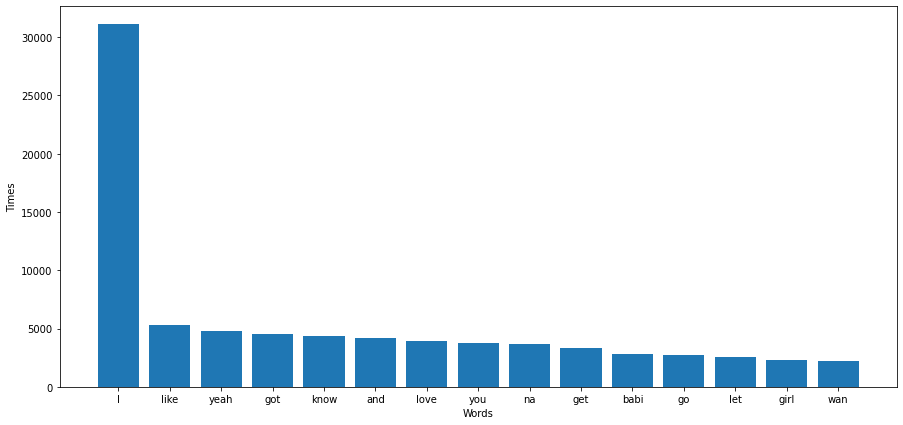

In [49]:
names = []
for i in zip(*columns_add_drop.top_words):
    names.append(i)

plt.figure(figsize = (15, 7))
plt.bar(names[0], names[1])
plt.xlabel('Words')
plt.ylabel('Times');

Biểu đồ trên cho thấy sự phân bố của một số từ xuất hiện nhiều nhất trong tập huấn luyện. Khi siêu tham số `num_words = 15`

Sau khi thực hiện các bước trên, thì hiện tại tất cả các cột đều ở dạng số (numerical) ngoại trừ cột `time_signature` thuộc dạng categorical.

Ta sẽ tiếp tục thực hiện một vài các bước tiền xử lý. Mặc dù, trong dữ liệu thu thập được không có giá trị thiếu, tuy nhiên ta vẫn sẽ chuẩn bị cho dữ liệu thực tế khi các trường này có thể có trường hợp thiếu dữ liệu.
- Với các thuộc dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean (giá trị trung bình) của cột. Sử dụng `SimpleImputer`.
- Với cột thuộc dạng categorical, ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất của cột). Sử dụng `SimpleImputer`
- Sau cùng, khi không còn các giá trị thiếu và tất cả đều ở dạng số thì ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn.


In [37]:
columns_trans = make_column_transformer(
            (SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'), ['time_signature']),
            remainder = SimpleImputer(missing_values = np.nan, strategy = 'mean')
        )

preprocess_pipeline = make_pipeline(dropExtractLyrics(), columns_trans, StandardScaler())
preprocess_pipeline

Pipeline(steps=[('dropextractlyrics', dropExtractLyrics()),
                ('columntransformer',
                 ColumnTransformer(remainder=SimpleImputer(),
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['time_signature'])])),
                ('standardscaler', StandardScaler())])

## Tiền xử lý + mô hình hóa

Ở đây chúng ta sẽ tiến hành thử nghiệm trên 4 mô hình phổ biến trong việc thực hiện classification. 
1. Mô hình MLP Classifier
2. Mô hình Logistic Regression
3. Mô hình Random Forest
4. Mô hình K-NN

Khi tiến hành thử nghiệm trên các mô hình này, vì dữ liệu của nhóm khá ít nên nhóm sẽ sử dụng phương pháp k-fold cross validation với k = 5.

Cũng như ta sẽ tiến hành thử nghiệm xem khi thay đổi siêu tham số `num_words` sẽ có tác động gì đến mô hình. Ta sẽ thử nghiệm với các giá trị [5, 10, 20, 30, 50]

### Mô hình MLP Classifier

In [ ]:
trainvalid_errors = []
test_errors = []

Ở đây ta sẽ sử dụng mô hình MLP (với các siêu tham số `hidden_layer_sizes = (20), activation = tanh, solver =lbfgs, max_iter = 2500, random_state = 0` ) cũng như phương pháp k-fold cross validation để huấn luyện mô hình. 


In [ ]:
neural_net_model = MLPClassifier(hidden_layer_sizes = (20), 
                                 activation = 'relu',
                                 solver = 'lbfgs', 
                                 max_iter = 2500,
                                 random_state = 0)

full_pipeline1 = make_pipeline(preprocess_pipeline, neural_net_model)
full_pipeline1

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropextractlyrics', dropExtractLyrics()),
                                 ('columntransformer',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['time_signature'])])),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

In [ ]:
scores = []
alphas = [0.1, 1, 10, 100, 1000]
num_words = [5, 10, 20, 30, 50]
for alpha in alphas:
    for num in num_words:
        full_pipeline1.set_params(mlpclassifier__alpha = alpha, pipeline__dropextractlyrics__num_words = num)
        scores.append(cross_val_score(full_pipeline1, train_X_df, train_y_sr, cv = 5))
    
errors = [(1-i)*100 for i in scores]
errors = [i.mean() for i in errors]
errors

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[43.912010705921716,
 41.620943459350954,
 43.33456005352961,
 42.926731348277016,
 42.51957176313148,
 43.012044161927065,
 42.0294412847106,
 43.74874539979926,
 42.43693542990967,
 43.416192706590834,
 35.89862830378054,
 37.61425225828036,
 38.101706256273005,
 37.77551020408163,
 40.30879892940783,
 35.322850451656066,
 35.40448310471729,
 35.240883238541315,
 35.07661425225828,
 35.15858146537303,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066]

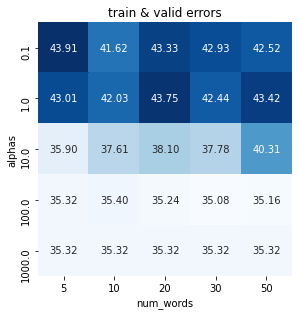

In [ ]:
train_errs_df = pd.DataFrame(data=np.array(errors).reshape(len(alphas), -1),
                             index=alphas, columns=num_words)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Blues')
plt.title('train & valid errors'); plt.xlabel('num_words'); plt.ylabel('alphas');

Qua dữ liệu trên tập train+valid ta thấy `alpha = 100` & `num_words` = 30 cho kết quả tốt nhất. Nên ta sẽ lựa chọn `alpha = 100` & `num_words = 30` để dự đoán trên tập test.

In [ ]:
trainvalid_errors.append(min(errors))

alpha_best = alphas[np.argmin(errors) % 5]
num_words_best = num_words[int(np.argmin(errors) / 5)]

full_pipeline1.set_params(mlpclassifier__alpha = alpha_best, pipeline__dropextractlyrics__num_words = num_words_best)
full_pipeline1.fit(train_X_df, train_y_sr)
preds = full_pipeline1.predict(test_X_df)
error = (1 - accuracy_score(test_y_sr, preds)) * 100
test_errors.append(error)
print(error)

36.111111111111114


Ta thấy mô hình có độ lỗi trên tập test là: ~36.1% tương tự như trên tập train+valid

In [ ]:
print(classification_report(test_y_sr, preds, target_names= ['non-hit', 'hit']))

              precision    recall  f1-score   support

     non-hit       0.65      0.96      0.78       140
         hit       0.38      0.04      0.07        76

    accuracy                           0.64       216
   macro avg       0.51      0.50      0.42       216
weighted avg       0.55      0.64      0.53       216



### Mô hình LogisticRegression

Tiếp theo ta sẽ thử nghiệm trên mô hình Logistic Regression với siêu tham số `max_iter = 2500` còn lại ta cho theo mặc định. Mô hình cũng được huấn luyện theo phương pháp k-fold cross validation (k=5)

In [38]:
num_words = [5, 10, 20, 30, 50]
scores =[]
full_pipeline2 = make_pipeline(preprocess_pipeline, LogisticRegression(max_iter = 2500))
for num in num_words:
    full_pipeline2.set_params(pipeline__dropextractlyrics__num_words = num)
    scores.append(cross_val_score(full_pipeline2, train_X_df, train_y_sr, cv = 5))


In [39]:
errors = [(1-i)*100 for i in scores]
errors = [i.mean() for i in errors]
errors

[35.978253596520574,
 34.99631983941117,
 36.05955168952827,
 35.405821344931425,
 36.223820675811304]

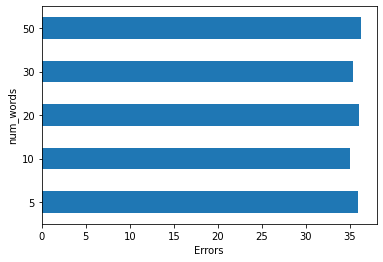

In [42]:
errors_df = pd.Series(errors, index = num_words).plot.barh()
plt.xlabel('Errors')
plt.ylabel('num_words')
plt.show();

Ta thấy, mô hình cho độ lỗi thấp nhất: ~35% trên tập train + valid với siêu tham số `num_words = 10`, ta tiếp tục cho mô hình dự đoán tập test.

In [ ]:
trainvalid_errors.append(min(errors))
num_words_best = num_words[np.argmin(errors)]
full_pipeline2.set_params(pipeline__dropextractlyrics__num_words = num_words_best)
full_pipeline2.fit(train_X_df, train_y_sr)
preds = full_pipeline2.predict(test_X_df)
error = (1 - accuracy_score(test_y_sr, preds)) * 100
test_errors.append(error)
print(error)

37.03703703703704


Mô hình cho ra độ lỗi: 37% trên tập test

In [ ]:
print(classification_report(test_y_sr, preds, target_names= ['non-hit', 'hit']))

              precision    recall  f1-score   support

     non-hit       0.65      0.91      0.76       140
         hit       0.40      0.11      0.17        76

    accuracy                           0.63       216
   macro avg       0.53      0.51      0.46       216
weighted avg       0.56      0.63      0.55       216



### Mô hình Random Forest

Với mô hình Random Forest ta sẽ thử nghiệm siêu tham số: `n_estimators` với các giá trị [100, 200, 300, 400, 500] cũng như phương pháp k-fold cross validation (k = 5)

In [ ]:
full_pipeline3 = make_pipeline(preprocess_pipeline, RandomForestClassifier(n_estimators = 100,max_depth=5, random_state=0))
full_pipeline3

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropextractlyrics', dropExtractLyrics()),
                                 ('columntransformer',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['time_signature'])])),
                                 ('standardscaler', StandardScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

In [ ]:
scores = []
n_estimators = [100,200,300,400,500]
num_words = [5, 10, 20, 30, 50]
for i in n_estimators:
  for num in num_words:
    full_pipeline3.set_params(randomforestclassifier__n_estimators = i, pipeline__dropextractlyrics__num_words = num)
    scores.append(cross_val_score(full_pipeline3, train_X_df, train_y_sr, cv = 5))

In [ ]:
errors = [(1-i)*100 for i in scores]
errors = [i.mean() for i in errors]
errors

[34.6701237872198,
 35.076614252258274,
 33.11575777852124,
 34.50485112077618,
 34.996988959518234,
 34.669120107059214,
 34.91301438608231,
 34.01505520240883,
 33.93174974907996,
 34.995650719304116,
 34.9966543994647,
 34.58614921378387,
 34.097691535630645,
 34.34058213449315,
 35.15991970558715,
 34.66878554700569,
 34.25894948143191,
 34.09702241552359,
 34.50485112077619,
 34.99598527935764,
 34.75175644028103,
 33.768484442957515,
 33.60588825694212,
 34.42288390766143,
 34.995316159250585]

Text(69.0, 0.5, 'n_estimators')

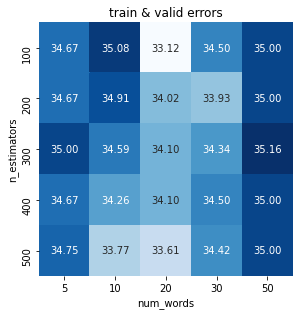

In [ ]:
train_errs_df = pd.DataFrame(data=np.array(errors).reshape(len(n_estimators), -1),
                             index=n_estimators, columns=num_words)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Blues')
plt.title('train & valid errors'); plt.xlabel('num_words'); plt.ylabel('n_estimators')

Ta thấy, mô hình cho độ lỗi nhỏ nhất trên tập train&valid khi siêu tham số: `n_estimators = 100` và `num_words = 20`. Ta sẽ tiến hành cho mô hình dự đoán trên tập test với 2 siêu tham số này.

In [ ]:
trainvalid_errors.append(min(errors))

In [ ]:
num_words_best = max_depth[np.argmin(errors) % 5]
n_estimators_best = n_estimators[int(np.argmin(errors) / 5)]

In [ ]:
full_pipeline3.set_params(randomforestclassifier__n_estimators = n_estimators_best,pipeline__dropextractlyrics__num_words = num_words_best)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropextractlyrics',
                                  dropExtractLyrics(num_words=8)),
                                 ('columntransformer',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['time_signature'])])),
                                 ('standardscaler', StandardScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, n_estimators=400,
                                        random_state=0))])

In [ ]:
full_pipeline3.fit(train_X_df, train_y_sr)
preds = full_pipeline3.predict(test_X_df)

In [ ]:
error = (1 - accuracy_score(test_y_sr, preds)) * 100
test_errors.append(error)
print(error)

36.57407407407407


Ta thấy, mô hình cho độ lỗi 36.57% trên tập test

In [ ]:
print(classification_report(test_y_sr, preds, target_names= ['non-hit', 'hit']))

              precision    recall  f1-score   support

     non-hit       0.64      0.96      0.77       140
         hit       0.25      0.03      0.05        76

    accuracy                           0.63       216
   macro avg       0.45      0.49      0.41       216
weighted avg       0.51      0.63      0.52       216



### Mô hình k-NN

Với mô hình k-NN ta sẽ tiến hành thử nghiệm với siêu tham số `n_neighbors` thuộc các giá trị [3, 9, 27, 81, 243] và tiếp tục huấn luyện với phương pháp k_fold cross validation (k = 5)

In [ ]:
full_pipeline5 = make_pipeline(preprocess_pipeline, KNeighborsClassifier())
full_pipeline5

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropextractlyrics',
                                  dropExtractLyrics(num_words=50)),
                                 ('columntransformer',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['time_signature'])])),
                                 ('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
scores = []
num_neighbors = [3, 9, 27, 81, 243]
num_words = [5, 10, 20, 30, 50]
for num in num_neighbors:
  for num_word in num_words:
    full_pipeline5.set_params(kneighborsclassifier__n_neighbors = num, pipeline__dropextractlyrics__num_words = num_word)
    scores.append(cross_val_score(full_pipeline5, train_X_df, train_y_sr, cv = 5))

Text(69.0, 0.5, 'num_neighbors')

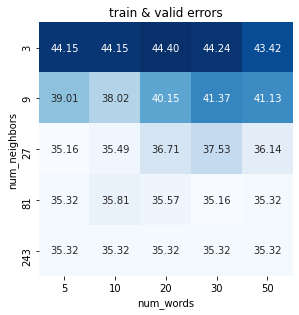

In [ ]:
train_errs_df = pd.DataFrame(data=np.array(errors).reshape(len(num_neighbors), -1),
                             index=num_neighbors, columns=num_words)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Blues')
plt.title('train & valid errors'); plt.xlabel('num_words'); plt.ylabel('num_neighbors')

In [ ]:
errors

[44.154232184677156,
 44.15490130478421,
 44.39946470391436,
 44.23686851789896,
 43.418534626965545,
 39.00568752091,
 38.02275008364001,
 40.147875543660085,
 41.37136165941787,
 41.127467380394776,
 35.160923385747736,
 35.488792238206756,
 36.71261291401807,
 37.52960856473737,
 36.13984610237537,
 35.323185011709604,
 35.814319170291064,
 35.569086651053865,
 35.159250585480095,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066,
 35.322850451656066]

Ta thấy mô hình cho độ lỗi nhỏ nhất là 35.16% với `n_neighbors = 81` và `num_words = 30`, ta sẽ sử dụng mô hình này để dự đoán trên tập test.

In [ ]:
num_words_best = num_words[np.argmin(errors) % 5]
num_neighbors_best = num_neighbors[int(np.argmin(errors) / 5)]
full_pipeline5.set_params(kneighborsclassifier__n_neighbors = num_neighbors_best,pipeline__dropextractlyrics__num_words = num_words_best)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropextractlyrics',
                                  dropExtractLyrics(num_words=30)),
                                 ('columntransformer',
                                  ColumnTransformer(remainder=SimpleImputer(),
                                                    transformers=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['time_signature'])])),
                                 ('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=81))])

In [ ]:
full_pipeline5.fit(train_X_df, train_y_sr)
preds = full_pipeline5.predict(test_X_df)
error = (1 - accuracy_score(test_y_sr, preds)) * 100
test_errors.append(error)
print(error)

35.18518518518518


Trên tập test, mô hình cũng cho độ lỗi tương tự: 35.19%

In [ ]:
print(classification_report(test_y_sr, preds, target_names= ['non-hit', 'hit']))

              precision    recall  f1-score   support

     non-hit       0.65      1.00      0.79       140
         hit       0.00      0.00      0.00        76

    accuracy                           0.65       216
   macro avg       0.32      0.50      0.39       216
weighted avg       0.42      0.65      0.51       216



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tuy nhiên, và đặc biệt ở mô hình này khi nhìn vào thông số `precision` và `recall` ở lớp dự đoán `hit ~ 1` thì đều có chỉ số bằng 0. Hay nói cách khác mô hình chỉ toàn dự đoán ra 0 mà không dự đoán được bài hát nào trên tập test là 1.

Có thể, do quy mô dữ liệu huấn luyện quá nhỏ nên đã không phù hợp với mô hình k-nn.

### Tổng kết

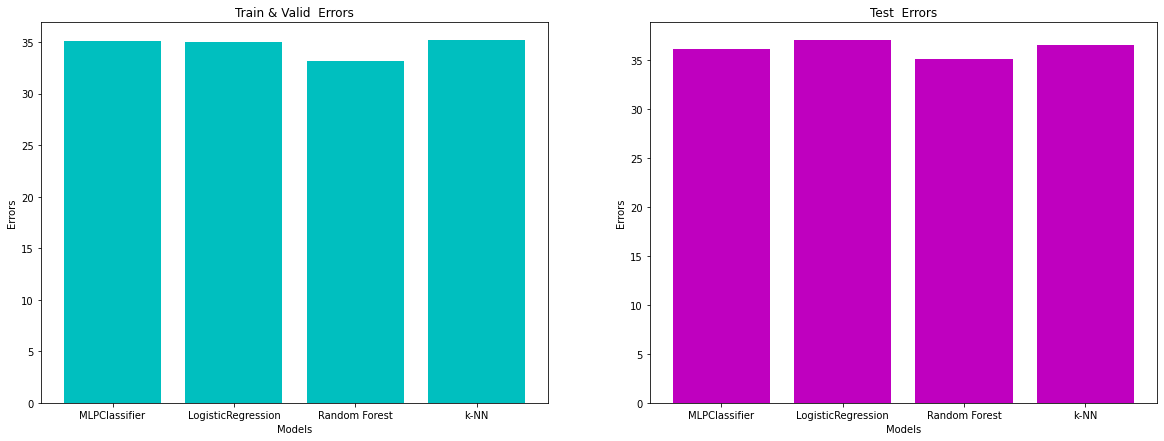

In [ ]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(20,7))
models = ['MLPClassifier', 'LogisticRegression', 'Random Forest', 'k-NN']
axs1.bar(models, trainvalid_errors, color = 'c')
axs1.set_title('Train & Valid  Errors')
axs1.set_xlabel('Models')
axs1.set_ylabel('Errors')

axs2.bar(models, test_errors, color = 'm')
axs2.set_title('Test  Errors')
axs2.set_xlabel('Models')
axs2.set_ylabel('Errors');

Thông qua 2 biểu đồ trên, ta có thể thấy cả 4 mô hình đều không hoạt động tốt trên cả dữ liệu train và test. Có lẽ do lý do khách quan là dữ liệu huấn luyện vẫn còn khá ít. 
- Mô hình Random Forest cho ra độ lỗi nhỏ nhất trong cả 2 tập: (train+valid) và tập test.
- Các mô hình còn lại cho ra độ lỗi khá tương tự nhau ~35 %

## Ý tưởng cải tiến

Có thể thấy các mô hình cho ra kết quả khá thấp. Nếu nhóm có nhiều thời gian hơn, nhóm sẽ thực hiện các phương pháp sau để cải thiện mô hình:
- Thu thập nhiều dữ liệu hơn: 
    - Mở rộng phạm vi tìm kiếm dữ liệu, từ việc chỉ xét đến những bài hát xuất hiện trên bảng xếp hạng cuối năm Billboard Hot 100. Thì ta có thể mở ra "toàn bộ" (nhiều nhất có thể) những bài hát của năm đó và những bài hát xuất hiện ở trong bảng xếp hạng thì sẽ được xem là đáng nghe.
    - Hiện tại, trong giai đoạn thu thập dữ liệu từ Spotify và Genius nhóm sử dụng thuần API từ 2 website này. Tuy nhiên, trong lúc sử dụng Search API để tìm kiếm bài hát trên 2 nền tảng này thì không phải lúc nào API cũng trả về kết quả như mong muốn. Do đó, khi mở rộng phạm vi tìm kiếm dữ liệu có lẽ nhóm sẽ chuyển sang sử dụng một số thư viện Python từ bên thứ 3 để hỗ trợ cho việc lấy dữ liệu: `spotipy` và `lyricsgenius`

- Làm nhiều điều hơn với dữ liệu lời bài hát:
    - Hiện tại, thì từ lời bài hát nhóm chỉ sử dụng những thông tin như: chỉ số tích cực/trung lập/tiêu cực, cũng như đếm số lần xuất hiện của một số từ `top_words` (những từ xuất hiện nhiều nhất) trong tập huấn luyện.
    - Tuy nhiên, từ lời bài hát ta có thể làm được nhiều điều hơn như rút trích ra chủ đề chính của bài hát. Một bài hát xuất hiện trên bảng xếp hạng có thể do bài hát đó có chủ đề liên quan tới một trong những chủ đề nóng nhất của năm tương ứng??

- Thử nghiệm với nhiều mô hình phức tạp hơn: DNN,...